<a href="https://colab.research.google.com/github/YoungHu1998/MVM/blob/main/MVM_SyntheticData_CP%26Tucker_GeneralInput.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import torch 
from sklearn.metrics import confusion_matrix
# from scipy.special import expit
# from sklearn.metrics import accuracy_score

[3 4 5]
(1000, 3, 4, 5)
(3,)
torch.Size([1000, 4])


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = asarray(a).shape
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


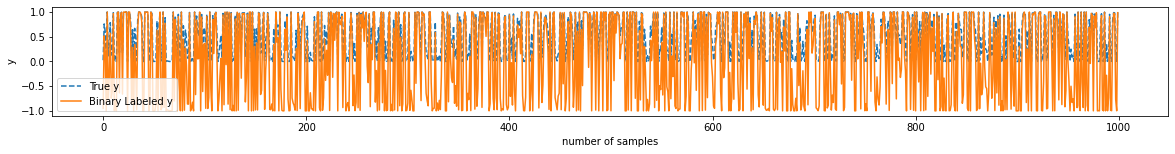

In [54]:
# need to compact and generalize 
# need to revise the generalizing of W later, 1st, generate B, then add some bias on the edges of B to form W
# Generate bianry y {-1, 1}
torch.random.manual_seed(4)
nv = [2, 3, 4]
nw = np.array(nv) +1
print(nw)
ns = 1000
v = [[],[],[]]
z = v
for i in np.arange(len(nv)):
  v[i] = torch.randn(ns,nv[i])
  z[i] = torch.hstack((v[i], torch.ones([ns,1])))
X = np.einsum('hi,hj,hk -> hijk',v[0], v[1], v[2])
# print(np.shape(X)) # (100, 3, 3, 3)
Z = np.einsum('hi,hj,hk -> hijk',z[0], z[1], z[2]) 
print(np.shape(Z)) # (100, 4, 4, 4)
W = torch.normal(0, 1, size=(nv[0]+1, nv[1]+1, nv[2]+1)).numpy()
# W = random_cp((4,4,4), rank=3, random_state=1234, full=False)
# y = np.einsum('hijk, ijk -> h', Z, W) 
y = 1/(1+ np.exp(-np.einsum('hijk, ijk -> h', Z, W)))
# print(y.size)
y_binary = 2*y - 1
t = np.arange(ns)
plt.figure(figsize=(20, 2))
plt.plot(t, y,'--', label='True y')
plt.plot(t, y_binary, label = 'Binary Labeled y')
plt.legend()
plt.xlabel('number of samples')
plt.ylabel('y')
# print(y_binary[0:5])
print(np.shape(z))
print(z[1].shape)

In [50]:
# !pip install tensorly
import tensorly as tl
from tensorly.decomposition import CP, parafac, tucker
from tensorly import cp_to_tensor, tucker_to_tensor
from tensorly.random import random_cp

## Tucker decomposition on W

In [28]:
from numpy.lib.function_base import diff
from numpy.core.einsumfunc import einsum
# from numpy.lib.function_base import diff
def Log_loss(y_hat, y):
  loss = np.log(1+np.exp(-np.dot(y,y_hat)))
  return loss
##################################Functions related to Tucker MVM###################################################
def diff_WZ_factors_Tucker(z, factors, G, i):
  # print('***********************diff_WZ*******************************')
  n = len(factors) # n is the Tucker rank
  B = [[]] * n
  for m in range(n):
    # print('np.shape(z[%s]):'%m, np.shape(z[m]), 'shape(factors[%s])'%m, np.shape(factors[m]))
    B[m] = torch.einsum('ij,jk -> ik',z[m].double(), torch.from_numpy(factors[m]).double())
    # print('size of B[ %s ]' %m, np.shape(B[m])) #the size should be ns * R_m
  B_temp = B
  # print('type(B[0]):',type(B[0]),'\n, type(B):', type(B))
  # print(np.shape(B))
  B_temp.pop(i)
  # print('type(B_temp)',type(B_temp))
  # print(np.shape(B_temp[0])[0],'\n', np.shape(B_temp[1])[1])
  # print('shape(B_temp[0]:',np.shape(B_temp[0]),'\n', 'shape(B_temp[1]',np.shape(B_temp[1]))
  # bb = torch.einsum('ij,ik -> ijk',bb_list[0], bb_list[1]) # i is the number of samples
  # print('shape of z[i]:', np.shape(z[i]))
  bb = np.empty(shape=(np.shape(z[i])[0], np.shape(B_temp[0])[1], np.shape(B_temp[1])[1]))
  # print('np.shape(bb):\n',np.shape(bb))
  zbb  = np.empty(shape=(np.shape(z[i])[0], np.shape(z[i])[1],np.shape(B_temp[0])[1], np.shape(B_temp[1])[1])) #ns * 4*3*3
  if i == 0:
    differential_wz = np.empty(shape=(np.shape(z[i])[0],np.shape(z[i])[1],np.shape(factors[i])[1]))
    bb = torch.einsum('ik,il->ikl',B_temp[0], B_temp[1])
    zbb = torch.einsum('ij, ikl ->ijkl', z[i],bb)
    # print('np.type(zbb):' ,type(zbb), '\n type of G:', type(G))
    # G = torch.from_numpy(G)
    differential_wz =  torch.einsum('ijkl,mkl->ijm',zbb.float(), G.float())
  elif i == 1:
    differential_wz = np.empty(shape=(np.shape(z[i])[0],np.shape(z[i])[1],np.shape(factors[i])[1]))
    bb = torch.einsum('ik,il->ikl',B_temp[0], B_temp[1])
    zbb = torch.einsum('ij, ikl ->ijkl', z[i],bb)
    # print('np.type(zbb):' ,type(zbb), '\n type of G:', type(G))
    # G = torch.from_numpy(G)
    differential_wz =  torch.einsum('ijkl,mkl->ijm',zbb.float(), G.float())
  elif i == 2:
    differential_wz = np.empty(shape=(np.shape(z[i])[0],np.shape(z[i])[1],np.shape(factors[i])[1]))
    bb = torch.einsum('ik,il->ikl',B_temp[0], B_temp[1])
    zbb = torch.einsum('ij, ikl ->ijkl', z[i],bb)
    # print('np.type(zbb):' ,type(zbb), '\n type of G:', type(G))
    # G = torch.from_numpy(G)
    differential_wz =  torch.einsum('ijkl,mkl->ijm',zbb.float(), G.float())
  # print('type of diff_WZ',type(differential_wz)) 
  # print('********************shape of diff_WZ:', np.shape(differential_wz))
  return differential_wz

 # the differential of Loss over the core tensor G
def diff_WZ_G_Tucker(z, factors): 
  # print('***********************diff_loss_G*******************************')
  Z = torch.einsum('hi,hj,hk -> hijk',z[0], z[1], z[2])
  # print('******diff_loss_G**********')
  # print('np.shape(Z):',np.shape(Z))
  # differential = np.empty(shape=(len(z), np.shape(factors[0])[1], np.shape(factors[1])[1], np.shape(factors[2])[1]))
  differential = torch.einsum('ab,cd,ef,iace->ibdf',torch.from_numpy(factors[0]).float(), torch.from_numpy(factors[1]).float(), torch.from_numpy(factors[2]).float(), Z)
  # print('type(differential)',type(differential))
  # print('*********************shape of diff_wz_G',np.shape(differential))
  # print('differentialG:', differential)
  return differential
def diff_loss_G(y, y_hat, z, factors):
  diff_wz_g = diff_WZ_G_Tucker(z=z, factors=factors)
  # print('shape of diff_wz_g:', np.shape(diff_wz_g))
  differential = -torch.einsum('i, ijkp->jkp', torch.from_numpy(y), diff_wz_g)/(1+ np.exp(np.dot(y,y_hat)))
  return differential
def diff_loss_factor_Tucker(y, y_hat, z, factors, G, i): #i here denotes the ith number of factor; B is a list of b_i # 三个factors貌似需要分开写
  # print('***************************diff_loss_factor*******************************')
  diff_wz = diff_WZ_factors_Tucker(z=z,factors=factors, G=G, i=i)
  # differential = -torch.einsum('i, ijm->jm', y, diff_wz)/(1+ np.exp(np.dot(y,y_hat)))
  # ValueError: einstein sum subscripts string contains too many subscripts for operand 1
  differential = np.empty(shape=(len(y),np.shape(factors[i])[0],np.shape(factors[i])[1]))
  # print('type of diff_loss_factor',type(differential))
  for m in range(len(y)):
    differential[m] = -y[m]*diff_wz[m]/(1+ np.exp(np.dot(y,y_hat)))
  Z = torch.einsum('hi,hj,hk -> hijk',z[0], z[1], z[2])
  W_hat = tl.tucker_to_tensor((G.numpy(), factors))
  W_hat = torch.from_numpy(W_hat)
  # print('***###tyep of W_hat and type of Z:',type(W_hat), type(Z))
  wz = torch.einsum('hijk, ijk -> h', Z.double(), W_hat)
  # diff_sigm = np.exp(-wz)/(np.dot(1+np.exp(-wz),1+np.exp(-wz)))
  # print(np.shape(y), np.shape(y_hat))
  # differential = -torch.einsum('i, ijk->jk', np.multiply(y, diff_sigm), diff_y)/(1+ np.exp(np.dot(y,y_hat)))
  differential = -torch.einsum('i, ijk->jk', torch.from_numpy(y), diff_wz)/(1+ np.exp(np.dot(y,y_hat)))
  # print('******************shape of differential_factors:', np.shape(differential))
  return differential

def train_MVM_Tucker(z, factors, G, y, bs, epochs, lr, n):# n is the number of the order/dimenisonality of the tensor, also the number of views
# bs is the batchsize
  # sp = np.shape(z)#shape of z matrix; sp[0] denotes the Z tensor dimentionality/order\  
  # ns = sp[1]
  # #sp[1] denotes the number of samples; #sp[3]denotes the I_p, to simplify the experiment, all I_p is 4 here; (3+1), 3 is the number of features in each view
  ns = len(factors)
  losses_iter = []
  losses_epoch = []
  mse_epoch = []
  mse_iter = []
  for epoch in range(epochs):
  # for epoch in range(2):
    losses_b = []
    mse_b = []
    # iterate all samples in the following iterations
    for tt in range((len(y)-1)//bs + 1):
      start_tt = tt * bs
      end_tt = start_tt + bs
      yb = y[start_tt:end_tt]
      # print("z shape", np.shape(z), type(z))
      zb = [[]] * ns
      for i in range(ns):
        zb[i] = z[i][start_tt:end_tt,:]
        # print('\n zb[%s]'%i,zb[i])
      Z = torch.einsum('ni,nj,nk -> nijk', zb[0],zb[1],zb[2])
      # print(type(factors))
      # print('type of G and type of factors',type(G),type(factors[0]))
      # print('shape of G and factors',np.shape(G), np.shape(factors[0]),np.shape(factors[1]), np.shape(factors[2]))
      # print('G:\n', G, '\nfactors[0]:\n',factors[0],'\nfactors[1]:\n',factors[1],'\nfactors[1]:\n',factors[1])
      W_hat = tl.tucker_to_tensor((G.numpy(), factors))
      # print('shape of W_hat',np.shape(W_hat))
      W_hat = torch.from_numpy(W_hat)
      # print('Z:\n', Z, '\n W_hat:', W_hat)
      # print('type of W_hat and type of Z:',type(W_hat), type(Z))
      # print('shape of W_hat and shape of Z:',np.shape(W_hat), np.shape(Z))
      temp_WZ = torch.einsum('ijk,nijk -> n', W_hat.float(), Z.float())
      # print('type of WZ',type(temp_WZ))
      y_hatb = 1/(1+torch.exp(-temp_WZ))
      if len(y_hatb) != len(yb):
        print('Error: len(y_hatb)!= len(yb)')
      for i in range(len(factors)):
        dA = diff_loss_factor_Tucker(y=yb, y_hat=y_hatb, z=zb, factors=factors, G=G, i=i)
        # print('np.shape(dA):', np.shape(dA))
        # dA = torch.mean(dA, 0, keepdim=True)
        # print('type(dA):',type(dA))
        # print('np.shape(dA):', np.shape(dA))
        # print('type(dA):',type(dA))
        factors[i] = factors[i] - lr * dA.numpy()
      dG = diff_loss_G(z=zb, factors=factors, y=yb, y_hat=y_hatb)
      # dG = torch.mean(dG, dim=0, keepdim=True)
      # dG = dG[0]
      # print('np.shape(dG)',np.shape(dG))
      # print('**************dG: ', dG,'**************')
      # print('G shape before iteration:',np.shape(G))
      # print('dG shape', np.shape(dG))
      G = G - lr * dG
      # print('G shape after iteration:',np.shape(G))
      mse = np.linalg.norm(W-W_hat.numpy())/np.size(W)
      # print('size(W):',np.size(W))
      l = Log_loss(y_hatb, yb)
      losses_b.append(l)
      # print('***************',tt,'*************')
      # print('len(losses_b):',len(losses_b))
      # print('l:', l)
      # print('losses_b:', losses_b)
      # print('yb',y,'\ny_hatb',y_hatb)
      mse_b.append(mse)
    losses_iter.extend(losses_b)
    losses_epoch.append(np.mean(losses_b))
    mse_iter.extend(mse_b)
    mse_epoch.append(np.mean(mse_b))
  return factors, G, losses_iter, losses_epoch, mse_epoch, mse_iter

  

In [57]:
##########################################Functions related to CP MVM##############################################
# def Log_loss(y_hat, y):
#   loss = np.log(1+np.exp(-np.dot(y,y_hat)))
#   return loss
def diff_loss_CP(y, y_hat, z, B, factors, i): #i denotes that the differential is over the ith factor A^(i)
  bb_torch = np.concatenate([B[0:i,:,:], B[i+1:,:,:]], axis=0)
  bb_torch = torch.from_numpy(bb_torch)
  bb = np.einsum('ij,ij -> ij',bb_torch[0,:,:], bb_torch[1,:,:]) # need be revised into a for-iteration form when generalizing #ns *3
  diff_wz =  np.einsum('ij,ik -> ijk', z[i], bb) 
  # print('************************np.shape(diff_wz):',np.shape(diff_wz))
  # print(np.shape(y))
  differential = -np.einsum('i, ijk->jk', y, diff_wz)/(1+ np.exp(np.dot(y,y_hat)))
  return differential
def train_MVM_CP(z, factors, y, bs, epochs, lr, n):# n is the number of the order/dimenisonality of the tensor, also the number of views
# bs is the batchsize
  losses_iter = []
  losses_epoch = []
  mse_iter = []
  mse_epoch = []
  # ns = len(factors)
  z = np.array(z)
  weights = np.ones(n)
  for epoch in range(epochs):
    losses_b = []
    mse_b = []
    # iterate all samples in the following iterations
    for tt in range((len(y)-1)//bs + 1):
      start_tt = tt * bs
      end_tt = start_tt + bs
      yb = y[start_tt:end_tt]
      zb = [[]] * n
      for i in range(n):
        zb[i] = z[i][start_tt:end_tt,:]
      temp = np.ones((len(yb), n))
      cp_rank = np.shape(factors[0])[1]
      Bb = np.empty((n,len(yb),cp_rank)) #Bb = list []length is tensor rank
      for j in np.arange(n):
        Bb[j] = np.dot(zb[j], factors[j])      #shape(n,k)
        temp = np.multiply(temp, Bb[j])
      y_hatb = np.sum(temp, axis=1)
      if len(y_hatb) != len(yb):
        print('Error: len(y_hat)!= len(y)')
      for i in range(len(factors)):
        dA = diff_loss_CP(y=yb, y_hat=y_hatb, z=zb, B=Bb, factors=factors, i=i)/len(yb)
        # print('np.shape(dA):',np.shape(dA))
        factors[i] = factors[i] - lr * dA
      W_hat = tl.cp_to_tensor([weights, factors])    
      l = Log_loss(y_hatb, yb)
      mse = np.linalg.norm(W-W_hat)/np.size(W)
      # print('size W',np.size(W))
      losses_b.append(l)
      # print('***************',tt,'*************')
      # print('len(losses_b):',len(losses_b))
      # print('l:', l)
      # print('losses_b:', losses_b)
      mse_b.append(mse)
    losses_iter.extend(losses_b)
    losses_epoch.append(np.mean(losses_b))
    mse_iter.extend(mse_b)
    mse_epoch.append(np.mean(mse_b))
  return factors, losses_iter, losses_epoch, mse_iter, mse_epoch
 

In [58]:
bs =  32
epochs = 100
lr = 0.01
cp_rank = 3
# init_factors_CP = torch.randn((len(nv),4,3)).tolist()
init_factors_CP = [np.random.randn(nw[0],cp_rank), np.random.randn(nw[1],cp_rank), np.random.randn(nw[2],cp_rank)]
CP_factors, Losses_ite_cp, Losses_epoch_cp, mse_iter_cp, mse_epoch_cp = train_MVM_CP(z=z, factors=init_factors_CP, y=y_binary, bs=bs, epochs=epochs, lr=lr, n=len(nv))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


[20.266517369741017, 13.538629533096906, 9.719933169873356, 7.189915834123632, 5.686508944628493, 4.732462877342301, 3.9766627116758984, 3.4329536656047384, 3.028873828036621, 2.6898172406275216, 2.3915257191468857, 2.1216380993292265, 1.8724548524414424, 1.6393959361626746, 1.4221079514921677, 1.2269581550453195, 1.0589699122723883, 0.9100584900796854, 0.7719078574551188, 0.6420272718235815, 0.5223582330413308, 0.4181511427532327, 0.33409868676030574, 0.2680481402922523, 0.21265076102037722, 0.16476221838844268, 0.12703328632622318, 0.10214793597810456, 0.08603755647321083, 0.07418160336672623, 0.06477710063908161, 0.05710455928144674, 0.050769199761500766, 0.04549783791562877, 0.04108108772485173, 0.03735330518049225, 0.034182791274664504, 0.031465032874762246, 0.029117228578623307, 0.027073743734576255, 0.02528240537912684, 0.02370155015051535, 0.022297712630607994, 0.02104383456195665, 0.019917884912302335, 0.018901797858327796, 0.01798065412988835, 0.01714204770165817, 0.016375593

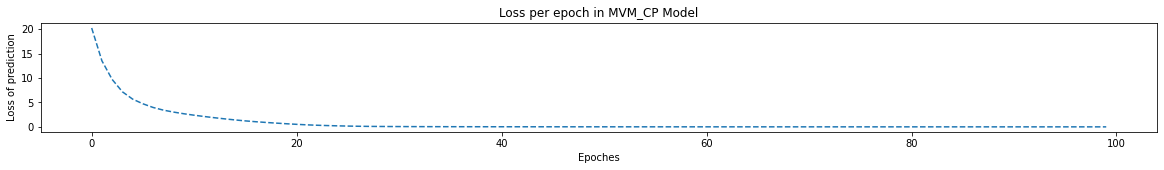

In [59]:
plt.figure(figsize=(20, 2))
# plt.ylim([-(1e-8), 1e-8])
plt.plot(Losses_epoch_cp,'--', label='Losses per epoch')
plt.title('Loss per epoch in MVM_CP Model')
plt.xlabel('Epoches')
plt.ylabel('Loss of prediction')
print(Losses_epoch_cp)

In [43]:
22bs_tucker = 128
epochs_tucker = 400
lr_tucker = 0.01
#initial factors:
init_factors_tucker = [np.random.randn(4,3), np.random.randn(4,3), np.random.randn(4,3)]
init_G = torch.randn((3,3,3))
# type(init_G)
tucker_factors, G, Losses_ite_tucker, Losses_epoch_tucker, mse_epoch_tucker, mse_iter_tucker = train_MVM_Tucker(z=z, factors=init_factors_tucker, G=init_G, y=y_binary, bs=bs_tucker, epochs=epochs_tucker, lr=lr_tucker, n=len(nv))

[0.196632232385691, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 

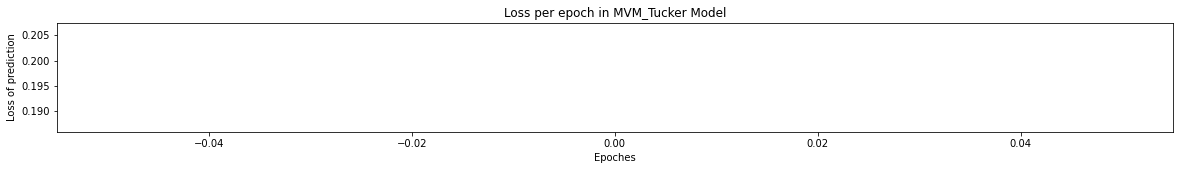

In [45]:
plt.figure(figsize=(20, 2))
# plt.ylim([-(1e-8), 1e-8])
plt.plot(Losses_epoch_tucker,'--', label='Losses per epoch')
plt.title('Loss per epoch in MVM_Tucker Model')
plt.xlabel('Epoches')
plt.ylabel('Loss of prediction')
print(Losses_epoch_tucker)

0.0003280582542082707
1.8381256848166884e-06


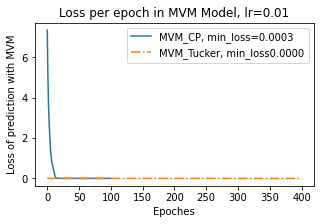

In [35]:
plt.figure(figsize=(5, 3))
t = np.arange(epochs)
t_tucker = np.arange(epochs_tucker)
# plt.ylim([-(1e-8), 1e-8])
plt.plot(t, Losses_epoch_cp,'', label='MVM_CP, min_loss=%.4f'%min(Losses_epoch_cp))
plt.plot(t_tucker, Losses_epoch_tucker,'-.', label='MVM_Tucker, min_loss%.4f'%min(Losses_epoch_tucker))
plt.title('Loss per epoch in MVM Model, lr=%s'%lr)
plt.xlabel('Epoches')
plt.ylabel('Loss of prediction with MVM')
plt.legend()
print(min(Losses_epoch_cp))
print(min(Losses_epoch_tucker))

6300


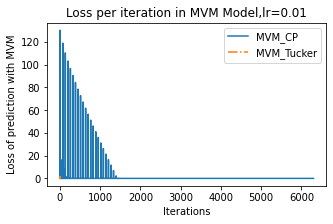

In [ ]:
plt.figure(figsize=(5,3))
# plt.ylim([-(1e-8), 1e-8])
plt.plot(Losses_ite_cp,'', label='MVM_CP')
plt.plot(Losses_ite_tucker,'-.', label='MVM_Tucker')
plt.title('Loss per iteration in MVM Model,lr=%s'%lr)
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss of prediction with MVM')
print(len(Losses_ite_cp))

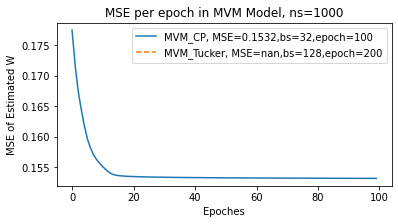

In [41]:
plt.figure(figsize=(6, 3))
# plt.ylim([-(1e-8), 1e-8])
plt.plot(mse_epoch_cp,'', label='MVM_CP, MSE=%.4f,bs=%s,epoch=%s'%(min(mse_epoch_cp),bs,epochs))
plt.plot(mse_epoch_tucker,'--', label='MVM_Tucker, MSE=%.4f,bs=%s,epoch=%s'%(min(mse_epoch_tucker),bs_tucker, epochs_tucker))
plt.title('MSE per epoch in MVM Model, ns=%s'%ns)
plt.xlabel('Epoches')
plt.ylabel('MSE of Estimated W')
plt.legend()
# print(mse_epoch)

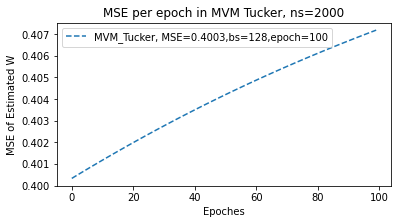

In [ ]:
plt.figure(figsize=(6, 3))
# plt.ylim([-(1e-8), 1e-8])
# plt.plot(mse_epoch_cp,'', label='MVM_CP, MSE=%.4f,bs=%s,epoch=%s'%(min(mse_epoch_cp),bs,epochs))
plt.plot(mse_epoch_tucker,'--', label='MVM_Tucker, MSE=%.4f,bs=%s,epoch=%s'%(min(mse_epoch_tucker),bs_tucker, epochs_tucker))
plt.title('MSE per epoch in MVM Tucker, ns=%s'%ns)
plt.xlabel('Epoches')
plt.ylabel('MSE of Estimated W')
plt.legend()
# print(mse_epoch)